# plot_comparison.ipynb

Author: Robert M. Frost

University of Oklahoma

Created: 06 November 2023

Purpose: Read in all cases to plot comparisons between them

In [2]:
import sys
sys.path.append("/home/rfrost/LES-utils/")

import seaborn
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MultipleLocator
from LESutils import load_full
import seaborn
import cmocean
from matplotlib.gridspec import GridSpec

### Settings

In [3]:
# directory to save figures
figdir = "/home/rfrost/manuscript_plots/"
# simulation to analyze
sims = ["full_step_6", "full_step_9", "full_step_12", "full_step_15"]

# z/zi to plot
height = 0.25

# start and end timesteps
t0 = 576000
t1 = 1152000
# start and end in hours
t0hr = t0 * 0.05 / 3600
t1hr = t1 * 0.05 / 3600
# spacing of output
dt = 1000

# lists to store stats, roll factor, and length scales
s_all, r_all, ls_all = [], [], []
# loop over sims
for sim in sims:
    dnc = f"/home/rfrost/simulations/nc/{sim}/"
    # volumetric stats
    s = xr.open_dataset(f"{dnc}{t0}_{t1}_stats.nc")
    # convert time to hours
    s["time"] = s.time / 3600 + t0hr
    s_all.append(s)

    # roll factor
    r = xr.open_dataset(f"{dnc}rollfactor.nc")
    # convert time to hours
    r["time"] = r.time / 3600 + t0hr
    r_all.append(r)

    # length scales
    ls = xr.open_dataset(f"{dnc}{t0}_{t1}_length_scale_rot.nc")
    # convert time to hours
    ls["time"] = ls.time / 3600 + t0hr
    ls_all.append(ls)

In [4]:
# plotting setup

# Set the font weight for plot titles
# plt.rcParams['axes.titleweight'] = 'bold'

# Set the font weight for x-axis and y-axis labels
plt.rcParams['axes.labelweight'] = 'normal'

# Other plotting setup
rc('font', family='sans-serif')
rc('font', weight='normal', size=20)
rc('figure', facecolor='white') 

Find minimum zi value after hour 13

In [5]:
# list of time where zi minimizes after hour 13
min_all, t_all = [], []
for i, s in enumerate(s_all):
    zimin = s.where(s.time >= 13, drop=True)
    min_all.append(zimin)
    tmin = np.argmin(zimin.zi.values)
    t_all.append(tmin)

### Vertical Profiles of $\theta'w'$ and $\theta$

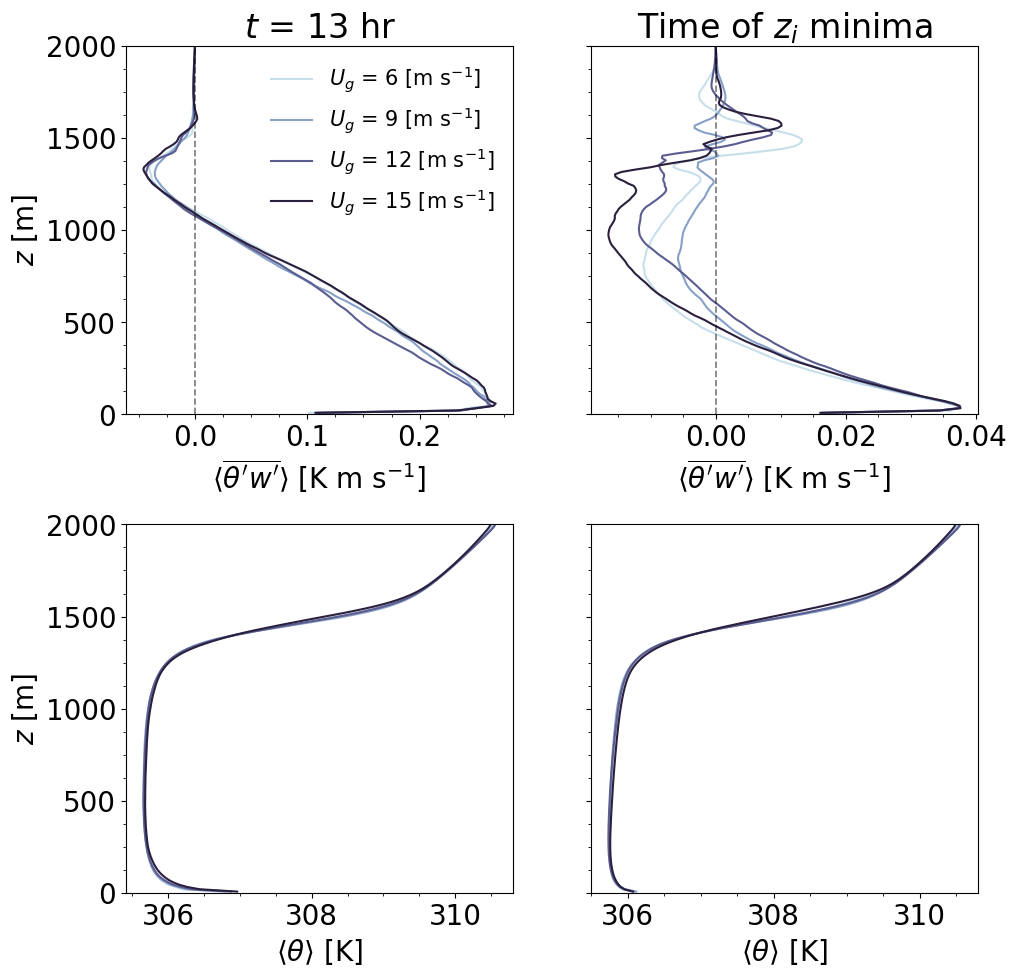

In [67]:
# colormap
colors = seaborn.color_palette("ch:s=.25,rot=-.25", 4)
# set labels
l = "sims[i][11:]"

fig, ax = plt.subplots(nrows=2, ncols=2 ,figsize=(11,11), sharey=True)

for i, s in enumerate(min_all):
    # t'w'
    ax[0,0].plot(s.tw_cov_res[0], s.z, c=colors[i], label=f"$U_g$ = {sims[i][10:]} [m s$^{{-1}}$]")
    ax[0,1].plot(s.tw_cov_res[t_all[i]], s.z, c=colors[i])
    # theta
    ax[1,0].plot(s.theta_mean[0], s.z, c=colors[i])
    ax[1,1].plot(s.theta_mean[t_all[i]], s.z, c=colors[i])

for i, iax in enumerate(ax[:,0]):
    # axis limits
    iax.set_ylim(0,2000)
    # axis labels
    iax.set_ylabel("$z$ [m]")
    # set ticks
    iax.yaxis.set_minor_locator(MultipleLocator(125))

for i, iax in enumerate(ax[0,:]):
    # vertical lines
    iax.axvline(x=0, ls="--", c="black", alpha=0.5, lw=1.25)
    # axis labels
    iax.set_xlabel("$\\langle \overline{\\theta'w'} \\rangle$ [K m s$^{-1}$]")

for i, iax in enumerate(ax[1,:]):
    # axis labels
    iax.set_xlabel("$\\langle \\theta \\rangle$ [K]")

# legend
ax[0,0].legend(frameon=False, loc="upper right", fontsize=15)

# set ticks
ax[0,0].xaxis.set_minor_locator(MultipleLocator(.025))
ax[0,1].xaxis.set_minor_locator(MultipleLocator(.005))
ax[1,0].xaxis.set_minor_locator(MultipleLocator(0.5))
ax[1,1].xaxis.set_minor_locator(MultipleLocator(0.5))

# titles
ax[0,0].set_title("$t$ = 13 hr")
ax[0,1].set_title("Time of $z_i$ minima")

plt.subplots_adjust(hspace=0.3)

### Vertical profiles of heat and momentum fluxes

In [7]:
# times to be plot in hours
jthr = [9.5, 11, 12.5, 14, 15.5]
jtall = [abs(s_all[0].time.values - jthr[jt]).argmin() for jt in range(len(jthr))]

In [41]:
# calculate TKE and theta*
for i, s in enumerate(s_all):
    s["tke"] = (1/2) * (s.uu_var + s.vv_var + s.ww_var)
    s["thetastar"] = s.tw_cov_tot[:,0] / s.wstar

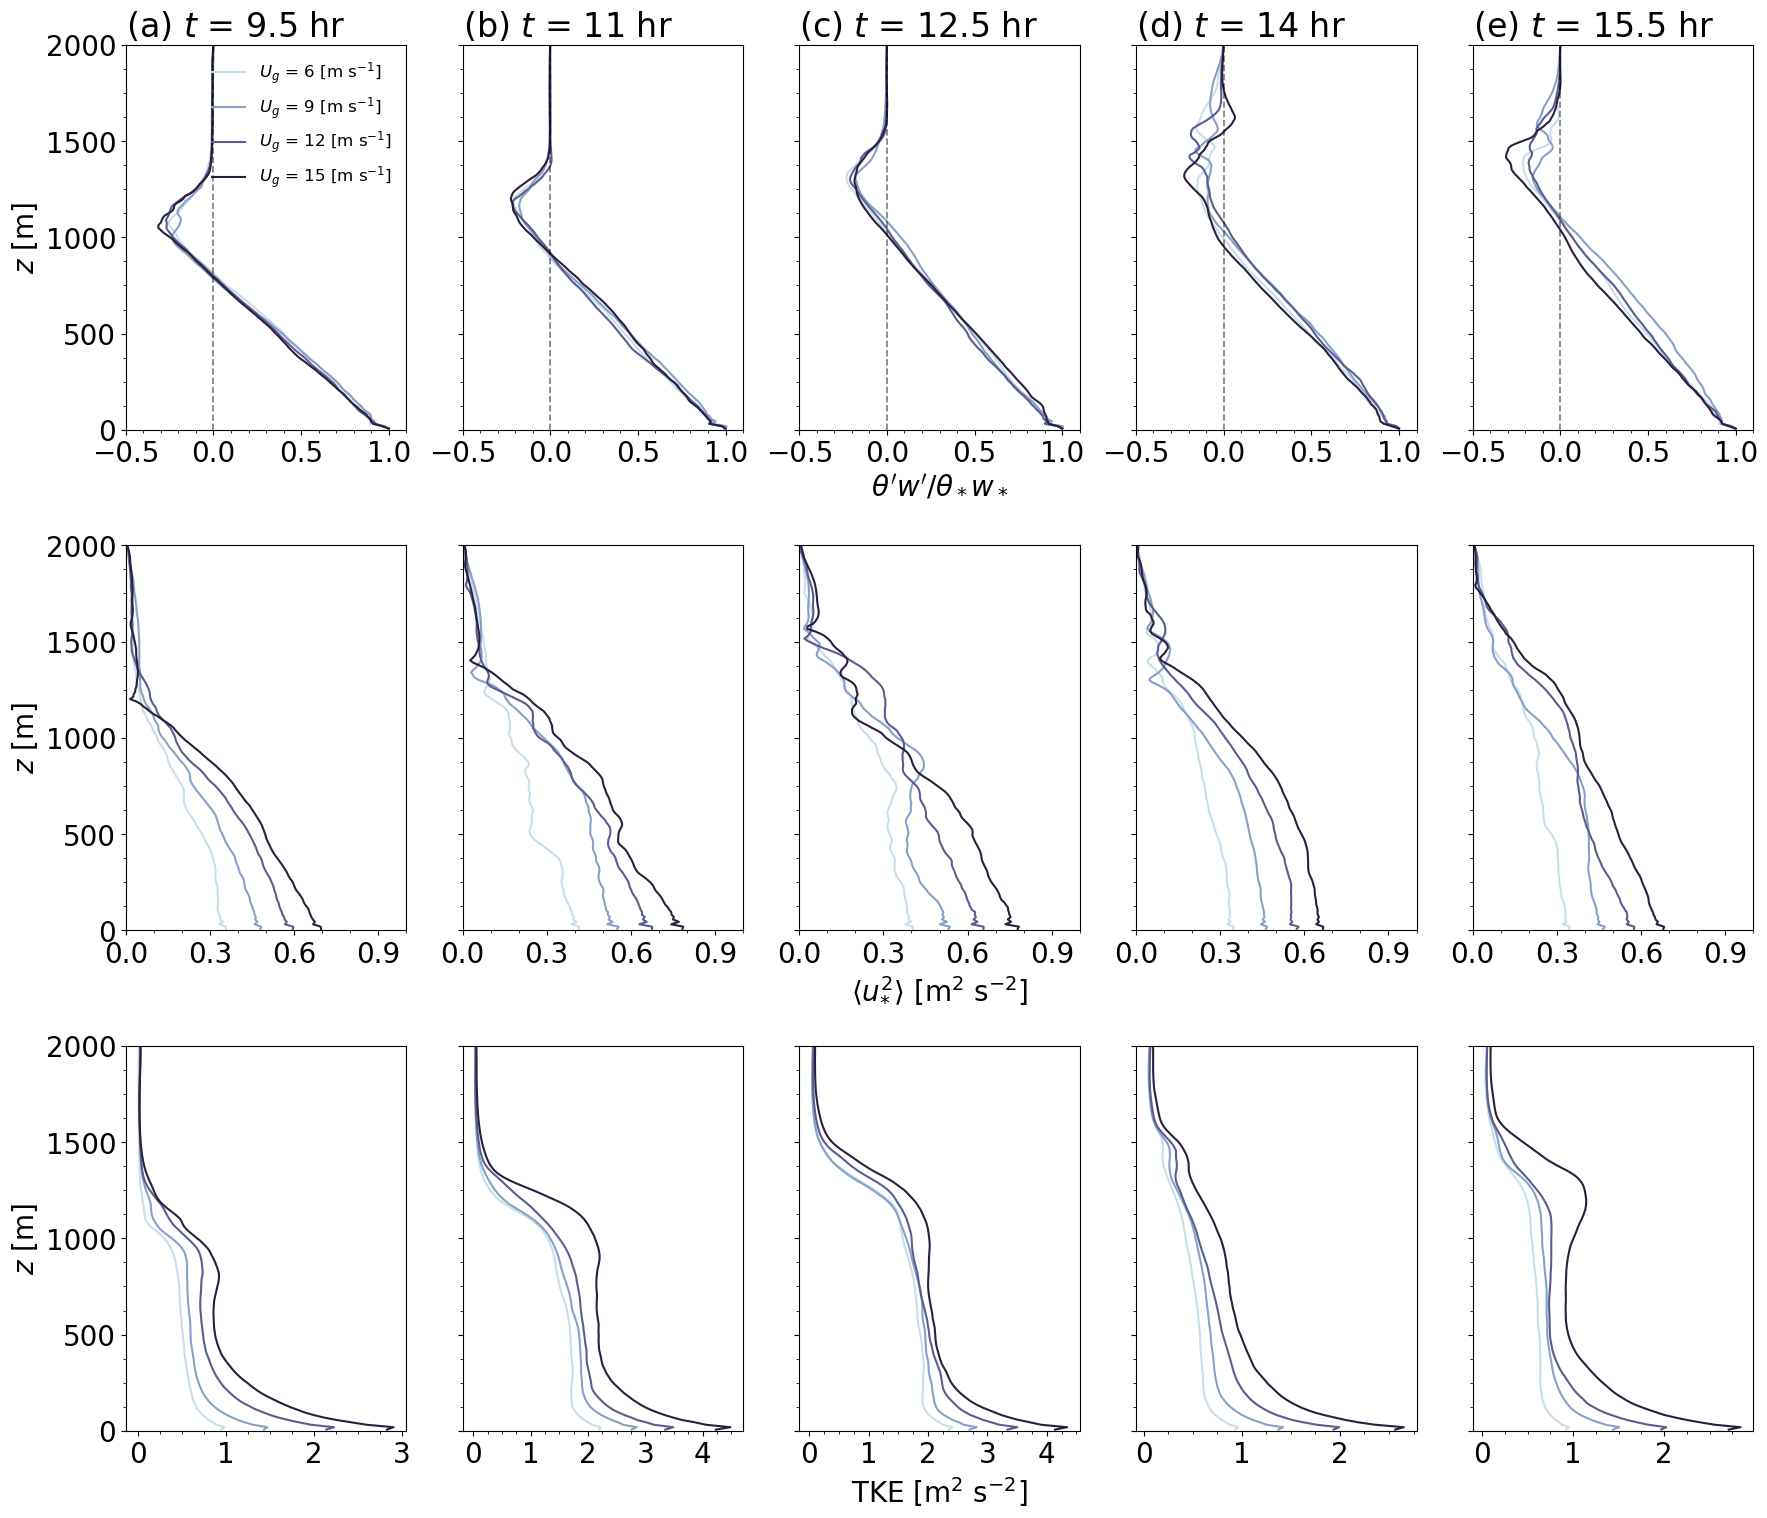

In [69]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(21,18), sharey=True)

for i, s in enumerate(s_all):
    # theta'w'
    ax[0,0].plot(s.tw_cov_tot[jtall[0]] / (s.thetastar * s.wstar).isel(time=jtall[0]), s.z,
               c=colors[i], label=f"$U_g$ = {sims[i][10:]} [m s$^{{-1}}$]")
    ax[0,1].plot(s.tw_cov_tot[jtall[1]]/ (s.thetastar * s.wstar).isel(time=jtall[1]), s.z,
               c=colors[i], label=f"$U_g$ = {sims[i][10:]} [m s$^{{-1}}$]")
    ax[0,2].plot(s.tw_cov_tot[jtall[2]]/ (s.thetastar * s.wstar).isel(time=jtall[2]), s.z,
               c=colors[i], label=f"$U_g$ = {sims[i][10:]} [m s$^{{-1}}$]")
    ax[0,3].plot(s.tw_cov_tot[jtall[3]]/ (s.thetastar * s.wstar).isel(time=jtall[3]), s.z,
               c=colors[i], label=f"$U_g$ = {sims[i][10:]} [m s$^{{-1}}$]")
    ax[0,4].plot(s.tw_cov_tot[jtall[4]]/ (s.thetastar * s.wstar).isel(time=jtall[4]), s.z,
               c=colors[i], label=f"$U_g$ = {sims[i][10:]} [m s$^{{-1}}$]")

    # u*^2
    ax[1,0].plot(s.ustar[jtall[0]], s.z, c=colors[i])
    ax[1,1].plot(s.ustar[jtall[1]], s.z, c=colors[i])
    ax[1,2].plot(s.ustar[jtall[2]], s.z, c=colors[i])
    ax[1,3].plot(s.ustar[jtall[3]], s.z, c=colors[i])
    ax[1,4].plot(s.ustar[jtall[4]], s.z, c=colors[i])

    # TKE
    ax[2,0].plot(s.tke[jtall[0]], s.z, c=colors[i])
    ax[2,1].plot(s.tke[jtall[1]], s.z, c=colors[i])
    ax[2,2].plot(s.tke[jtall[2]], s.z, c=colors[i])
    ax[2,3].plot(s.tke[jtall[3]], s.z, c=colors[i])
    ax[2,4].plot(s.tke[jtall[4]], s.z, c=colors[i])

# clean up heat flux plots
for i, iax in enumerate(ax[0,:]):
    sub_name = "abcde"
    iax.set_title(f"({sub_name[i]}) $t$ = {jthr[i]} hr", loc="left")
    iax.set_xlim(-0.5,1.1)
    iax.xaxis.set_major_locator(MultipleLocator(0.5))
    iax.xaxis.set_minor_locator(MultipleLocator(0.1))
    iax.axvline(x=0, ls="--", c="black", alpha=0.5, lw=1.25)

# clean up velocity variance plots
for i, iax in enumerate(ax[1,:]):
    iax.set_xlim(0,1)
    iax.xaxis.set_major_locator(MultipleLocator(0.3))
    iax.xaxis.set_minor_locator(MultipleLocator(0.1))

# clean up TKE plots
for i, iax in enumerate(ax[2,:]):
    iax.xaxis.set_major_locator(MultipleLocator(1))
    iax.xaxis.set_minor_locator(MultipleLocator(0.25))

# overall clean up
for i, iax in enumerate(ax[:,0]):
    iax.set_ylim(0,2000)
    iax.yaxis.set_minor_locator(MultipleLocator(125))
    iax.set_ylabel("$z$ [m]")


# variable labels
ax[0,2].set_xlabel("$ \\theta ' w' / \\theta_* w_*$")
ax[1,2].set_xlabel("$\\langle u_{*}^{2} \\rangle$ [m$^2$ s$^{-2}$]")
ax[2,2].set_xlabel("TKE [m$^2$ s$^{-2}$]")

# legend
ax[0,0].legend(frameon=False, fontsize=12, loc="upper right")

plt.subplots_adjust(hspace=0.3)